In [214]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

In [134]:
ins_data = pd.read_csv('Insurance_Company_Complaints__Resolutions__Status__and_Recoveries.csv')
ins_data = ins_data.dropna(subset=['Coverage'])
auto_data = ins_data[ins_data['Coverage'].str.contains('Auto')]
auto_data = auto_data[~auto_data.duplicated(subset='File No.', keep='last')]

# Hypothesis Testing
* After EDA, it appears that some insurers have higher complaint rates than others. While it is not appropriate to run a hypothesis test on a dataset already explored, but in order to demonstrate how a hypothesis test would be employed, I used data from the dataset that wasn't included in my initial analysis - which insurers were referring cases to legal counsel. 
* I assumed a binomial distribution with the following parameters: 
    * n = total number of complaint files for GEICO General and for Progressive Direct, 271 and 213, respectively. 
    * p = 0.09 (total cases referred to legal/total cases) = 355/3823
    * Because the industry rate at which *claims (not complaints)* go to litigation is 5%, 9% seems like a reasonable estimate
    * $\alpha$ = 0.05
* I performed one-sample hypothesis tests on GEICO General Insurance Company
* I performed two-sample hypothesis test on GEICO General and Allstate Fire and Casualty
*Note:* GEICO General and Progressive Direct might not be the best companies to compare, as it's possible their risk pool of insured is different. (See README.md) for a discussion of this. However, I chose these two companies because they represented the highest and lowest complaint rates, respectively, after normalizing for company size.


# One Sample Hypothesis test for GEICO General Insurance Company

#### Companies with higher complaint rates will have more cases be referred to legal
* $H_0$: GEICO General will refer cases to legal counsel no more than 9% of the time.
* $H_a$: GEICO General will refer cases to legal more than 9% of the time.

In [192]:
# total number of complaints for GEICO general
GEICO_tot_counts = auto_data[auto_data['Company'] == 'GEICO General Insurance Company']['File No.'].count()
GEICO_tot_counts

273

In [204]:
# Finding actual counts where cases were referred to legal
auto_jud = auto_data[(auto_data['Disposition'] == 'Refer-Judicial/Attorney')]
GEICO_gen_referral = auto_jud[auto_jud['Company'] == 'GEICO General Insurance Company']['Company'].count()

In [196]:
# create binomial distribution and normal for the null
GEICO_distribution = stats.binom(n=273, p=0.09)
GEICO_normal = stats.norm(loc=(273 * 0.09), scale=(np.sqrt(273 * 0.09 * 0.91)))

In [198]:
# null hypothesis is p<=0.09
print(f'p_value: {1 - GEICO_distribution.cdf(24)}')
print(f'Threshold to reject the null: {GEICO_distribution.ppf(0.95)}')
print('Fail to reject the null hypothesis for GEICO General')

p_value: 0.49431141898784503
Threshold to reject the null: 33.0
Fail to reject the null hypothesis for GEICO General


## Two Sample Test

From the EDA in the health insurer notebook, we see that GEICO General has the highest normalized complaint rate, and  Allstate Fire and Casualty Insurance the lowest.

* $H_0$: GEICO General refers cases to legal at a higher rate than does Allstate F&C
* $H_a$: GEICO General does not refer cases to legal at a higher rate than does Allstate F&C


GEICO referred 24 cases to legal. Allstate F&C referred 72 cases to legal. 

In [209]:
AFC_tot_counts = auto_data[auto_data['Company'] == 'Allstate Fire and Casualty Insurance Company']['File No.'].count()
AFC_referrals = auto_jud[auto_jud['Company'] == 'Allstate Fire and Casualty Insurance Company']['Company'].count()


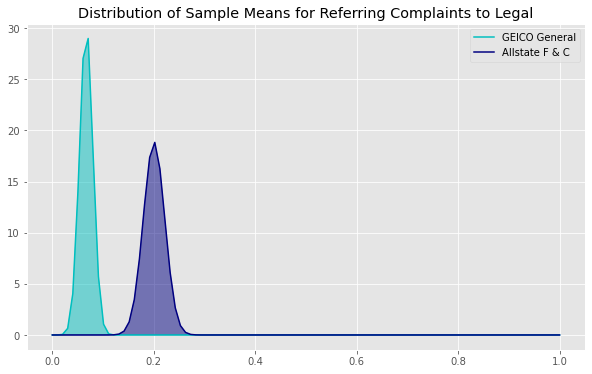

In [216]:
# Setting up sample size, and the proportions that each gets correct out of the sample size. 

geico_n= GEICO_tot_counts
AFC_n = AFC_tot_counts
GEICO_proportion = GEICO_gen_referrals/GEICO_tot_counts
AFC_proportion = AFC_referrals/AFC_tot_counts

#sampling distribution

GEICO_sample_mean = GEICO_proportion
AFC_sample_mean = AFC_proportion

# Create new variable for the population standard deviations. 
GEICO_sd = np.sqrt(GEICO_proportion * (1-GEICO_proportion))
AFC_sd = np.sqrt(AFC_proportion * (1-AFC_proportion))

# Calculating the standard deviation for the sample mean. 
GEICO_sample_mean_sd = GEICO_sd / np.sqrt(geico_n)
AFC_sample_mean_sd = AFC_sd / np.sqrt(AFC_n)

# Creating a plot
fig,ax = plt.subplots(figsize=(10, 6))

# Creating normal distributions for sample means and sample mean standard deviations.
# So these are the sampling distributions for the sample mean.
geico = stats.norm(GEICO_sample_mean, GEICO_sample_mean_sd)
AFC = stats.norm(AFC_sample_mean, AFC_sample_mean_sd)

# Creating a new array to use for x-axis. 
support = np.linspace(0, 1, 100)

# call the probability density functions for each of the points on the x axis. 
geico_pdf = geico.pdf(support)
AFC_pdf = AFC.pdf(support)

# Plot the density functions we just created and filling with color to show overlap.
# alpha here is transparency.
ax.plot(support, geico_pdf, color='c', label='GEICO General')
ax.fill(support, geico_pdf, color='c', alpha=0.5)
ax.plot(support, AFC_pdf, color='navy', label='Allstate F & C')
ax.fill(support, AFC_pdf, color='navy', alpha=0.5)


# Also add a plot title.
ax.legend()
ax.set_title("Distribution of Sample Means for Referring Complaints to Legal")
plt.savefig('Dist_of_sample_means_legal')

In [213]:
# Will use Welsch's t-test, as it is applicable in the majority of situations
geico_n= GEICO_tot_counts
AFC_n = AFC_tot_counts
GEICO_proportion = GEICO_gen_referrals/GEICO_tot_counts
AFC_proportion = AFC_referrals/AFC_tot_counts
geico_refer = [1]*int(geico_n*GEICO_proportion)
geico_no_refer = [0]*int(geico_n*(1-GEICO_proportion))

geico_sample = np.array(geico_refer + geico_no_refer)
AFC_sample = np.array([1]*int(AFC_n*AFC_proportion) + [0]*int(AFC_n*(1-AFC_proportion)))

print("Welch's t-test:")
print(stats.ttest_ind(geico_sample, AFC_sample, equal_var=False))


# Reject the Null

Welch's t-test:
Ttest_indResult(statistic=-5.360577016812393, pvalue=1.1849418038090556e-07)


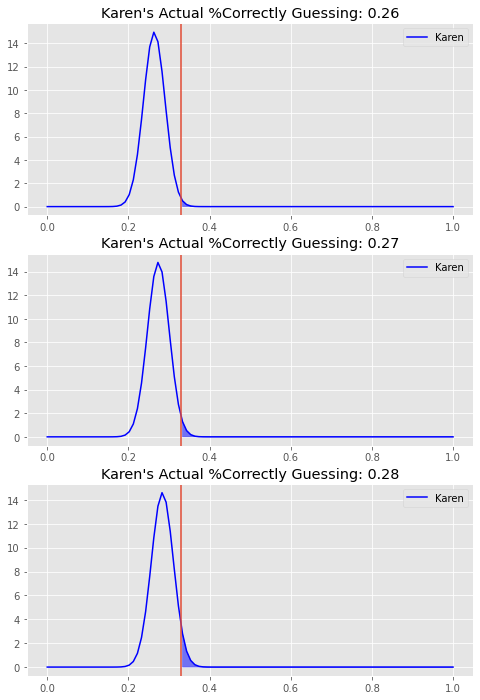

In [157]:
# set up my subplots
fig,axes = plt.subplots(3, figsize = (8, 12))

# for each subplot we're going to iterate through and capture the index and the plot object
for ax_idx, ax in enumerate(axes):

    # Setting up the n and ps for the distributions. 
    # We want to vary the actual value for Karen's correct guessing rate. (not the sampled value)
    n=273
    null_proportion = 0.09
    karen_proportion = 72/273 + 0.01 * ax_idx

    # sampling distribution
    # Stating that karen's true guessing rate should be the sample mean
    karen_sample_mean = karen_proportion
    
    # Establish the standard deviation for Karen's guessing rate
    karen_sd = np.sqrt(karen_proportion * (1-karen_proportion))
    
    # This is the standard deviation for Karen's sample mean. 
    karen_sample_mean_sd = karen_sd / np.sqrt(n)

    # Create a normal distribution for Karen's sample mean. 
    karen = stats.norm(karen_sample_mean, karen_sample_mean_sd)

    # Create sample space of a 100 points between 0.1 and 0.6
    support = np.linspace(0, 1, 100)
    # Finding the pdf at each of these points.
    karen_pdf = karen.pdf(support)

    # Finding the number where we reject the null hypothesis.
    null_mean = 0.3
    null_sd = np.sqrt((null_proportion * (1-null_proportion))/n)
    critical_value_dist = stats.norm(0.3, null_sd)
    critical_value = critical_value_dist.ppf(0.95)
    # find the inddex of the support where it becomes greater than the critical value (threshold)
    critical_value_idx = np.argmax(support>critical_value)
    
    # Plots
    ax.plot(support, karen_pdf, color='blue', label='Karen')
    # axvline is for a vertical line
    ax.axvline(critical_value)
    # there's some weird magic here for doing fill. 
    # basically fill is going to shade a shape that is bounded by points. 
    ax.fill(np.append(support[critical_value_idx], support[critical_value_idx:]), 
            np.append(0, karen_pdf[critical_value_idx:]), color='blue', alpha=0.5)
    
    # this doesn't work right:
    # ax.fill(support[critical_value_idx:], karen_pdf[critical_value_idx:], color='blue', alpha=0.5)

    # Try ax.fillbetwen!
    
    # legend and title
    ax.legend()
    ax.set_title("Karen's Actual %Correctly Guessing: {:.2f}".format(karen_proportion))

In [ ]:
# Geico General vs Casualty 
# Setting up sample size, and the proportions that each gets correct out of the sample size. 

geico_gen_n= 273
geico_cas_n = 201
GEICO_proportion = GEICO_gen_referrals/GEICO_tot_counts
Progressive_proportion = prog_direct_referrals/Progressive_tot_counts

## sampling distribution

# Assigning each person's proportion to the sample mean. We can do this because by 
# definition the estimate for sample mean is the same as the population mean.
GEICO_sample_mean = GEICO_proportion
Progressive_sample_mean = Progressive_proportion

# Create new variable for the population standard deviations. 
GEICO_sd = np.sqrt(GEICO_proportion * (1-GEICO_proportion))
Progressive_sd = np.sqrt(Progressive_proportion * (1-Progressive_proportion))

# Calculating the standard deviation for the sample mean. 
GEICO_sample_mean_sd = GEICO_sd / np.sqrt(geico_n)
Progressive_sample_mean_sd = Progressive_sd / np.sqrt(progressive_n)

# Creating a plot
fig,ax = plt.subplots(figsize=(10, 6))

# Creating normal distributions for sample means and sample mean standard deviations.
# So these are the sampling distributions for the sample mean.
geico = stats.norm(GEICO_sample_mean, GEICO_sample_mean_sd)
progressive = stats.norm(Progressive_sample_mean, Progressive_sample_mean_sd)

# Creating a new array to use for x-axis. 
support = np.linspace(0, 1, 100)

# call the probability density functions for each of the points on the x axis. 
geico_pdf = geico.pdf(support)
progressive_pdf = progressive.pdf(support)

# Plot the density functions we just created and filling with color to show overlap.
# alpha here is transparency.
ax.plot(support, geico_pdf, color='c', label='GEICO General')
ax.fill(support, geico_pdf, color='c', alpha=0.5)
ax.plot(support, progressive_pdf, color='navy', label='Progressive Direct')
ax.fill(support, progressive_pdf, color='navy', alpha=0.5)


# Also add a plot title.
ax.legend()
ax.set_title("Distribution of Sample Means for Referring Complaints to Legal")
plt.savefig('Dist_of_sample_means_legal')

In [168]:
# Attempted to do a hypothesis test with health insurers, but there was only one case that was referred to legal
health_data = ins_data[ins_data['Coverage'].str.contains('Health')]
health_data = health_data[~health_data.duplicated(subset='File No.', keep='last')]

health_data[health_data['Disposition']== 'Refer-Judicial/Attorney']

,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Conclusion,Recovery,Status
9207,Cigna Health and Life Insurance Company,900369,01/23/2019,01/23/2019,Group Health,Data Breach,Utilization Review,Case Management,Refer-Judicial/Attorney,Furnished Information,0.0,Closed


In [241]:
not_referred = auto_data[auto_data['Disposition'] != 'Refer-Judicial/Attorney']['Conclusion'].value_counts()
referred = auto_data[auto_data['Disposition'] == 'Refer-Judicial/Attorney']['Conclusion'].value_counts()
not_referred_percent = not_referred.apply(lambda x: x/not_referred.sum()*100)
referred_percent = referred.apply(lambda x: x/355*100)
print(referred_percent)
print(not_referred_percent)

Unjustified     60.281690
Questionable    27.605634
Justified       12.112676
Name: Conclusion, dtype: float64
Unjustified              75.448926
Justified                15.042685
Questionable              3.856344
No Action Necessary       3.355902
Voluntary Reconsider      1.383574
Furnished Information     0.677068
No Authority              0.235502
Name: Conclusion, dtype: float64


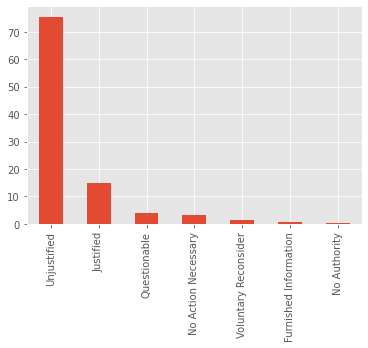

In [229]:
not_referred_percent.plot(kind='bar')

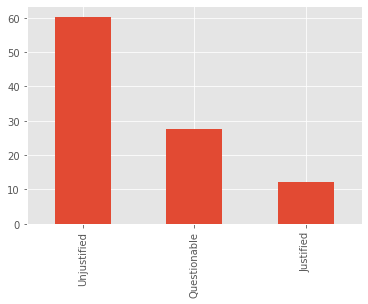

In [240]:
referred_percent.plot(kind='bar')